# Regression using a Neural Network (Keras)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [47]:
import tensorflow.keras as keras
import sys
sys.modules['keras'] = keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd

In [48]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [49]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [50]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [51]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [52]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [53]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

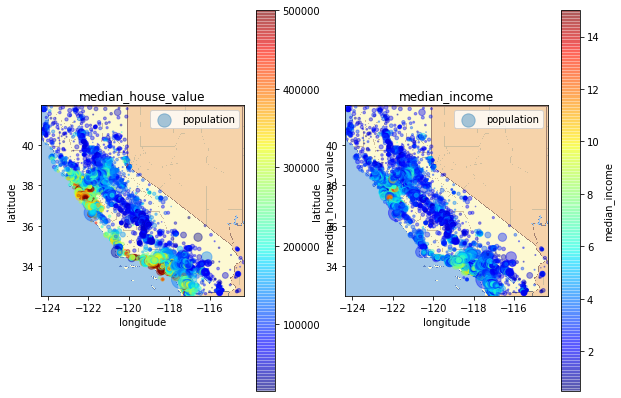

In [54]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [55]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [56]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [57]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [58]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [59]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [60]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [61]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [62]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [63]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
linear_model.coef_

array([-0.5266758 , -0.47057664,  0.11070029, -0.3135648 ,  0.8725257 ,
       -2.8026886 ,  1.0090159 ,  1.130491  , -0.04725069, -0.12498099,
        0.2653832 , -0.05613023, -0.0370255 ], dtype=float32)

In [65]:
linear_model.intercept_

0.54965496

Evaluate model on testing set
MSE= 0.018863907
MAE= 0.09931182
MAPE= 0.28951442


Text(0, 0.5, 'Y_test_pred')

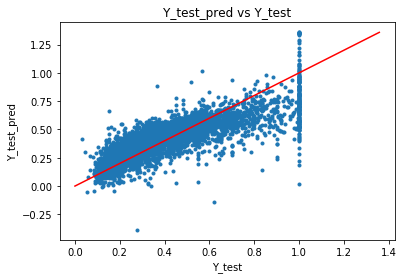

In [66]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Keras.ipynb

#### define the model

In [67]:
model = Sequential()
model.add(Dense(units=16, activation='softplus', input_shape=(13,)))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                224       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


#### Now, let's train the model for 100 epochs

In [68]:
loss_train_list=[]
loss_val_list=[]

In [69]:
for epoch in range(0, 100):
    #set epochs=1
    print('epoch', epoch)
    history=model.fit(X_train, Y_train, batch_size=8, epochs=1, validation_data=(X_val, Y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])

epoch 0
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 257us/sample - loss: 0.0323 - val_loss: 0.0228
epoch 1
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 262us/sample - loss: 0.0235 - val_loss: 0.0259
epoch 2
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 241us/sample - loss: 0.0224 - val_loss: 0.0222
epoch 3
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 253us/sample - loss: 0.0221 - val_loss: 0.0217
epoch 4
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 279us/sample - loss: 0.0218 - val_loss: 0.0219
epoch 5
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 4s 271us/sample - loss: 0.0213 - val_loss: 0.0217
epoch 6
Train on 14860 samples, validate on 1652 samples
14860/14860 [======

epoch 53
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 223us/sample - loss: 0.0182 - val_loss: 0.0197
epoch 54
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 224us/sample - loss: 0.0183 - val_loss: 0.0190
epoch 55
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 224us/sample - loss: 0.0179 - val_loss: 0.0192
epoch 56
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 229us/sample - loss: 0.0179 - val_loss: 0.0205
epoch 57
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 226us/sample - loss: 0.0179 - val_loss: 0.0196
epoch 58
Train on 14860 samples, validate on 1652 samples
14860/14860 [==============================] - 3s 224us/sample - loss: 0.0179 - val_loss: 0.0190
epoch 59
Train on 14860 samples, validate on 1652 samples
14860/14860 

plot the loss vs epoch curve

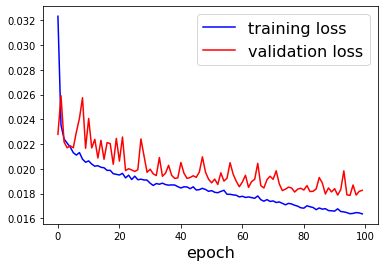

In [70]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

after training, we evaluate the model on the test dataset

In [71]:
# get the loss on test set
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score)

Test loss: 0.016780937191589858


In [72]:
#get Yp_test by using model.predict
Yp_test=model.predict(X_test, batch_size=64)

In [73]:
type(Yp_test)

numpy.ndarray

In [74]:
Yp_test.shape

(4128, 1)

In [75]:
Yp_test=Yp_test.squeeze()

In [76]:
Yp_test.shape

(4128,)

In [77]:
Y_test.shape

(4128,)

In [78]:
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)

print('Evaluate model on testing set')
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on testing set
Evaluate model on testing set
MSE= 0.016780939
MAE= 0.09312906
MAPE= 0.27532867


Text(0, 0.5, 'Y_test_pred')

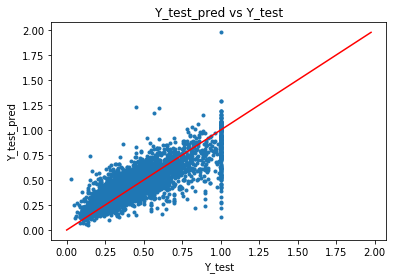

In [79]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Yp_test, '.')
ymax=np.max([Y_test.max(), Yp_test.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

### change the structure of the MLP model and see if it can do better than XGBoost

In [80]:
#define a new model
# all softplus as activation function
model = Sequential()
model.add(Dense(units=16, activation='softplus', input_shape=(13,)))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=1, activation='softplus'))
model.compile(loss='mse', optimizer=Adam())
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [81]:
#train, validate and test the model
history=model.fit(X_train, Y_train, batch_size=8, epochs=10, validation_data=(X_val, Y_val))

Train on 14860 samples, validate on 1652 samples
Epoch 1/10
14860/14860 [==============================] - 4s 246us/sample - loss: 0.0442 - val_loss: 0.0253
Epoch 2/10
14860/14860 [==============================] - 3s 226us/sample - loss: 0.0226 - val_loss: 0.0231
Epoch 3/10
14860/14860 [==============================] - 3s 229us/sample - loss: 0.0214 - val_loss: 0.0223
Epoch 4/10
14860/14860 [==============================] - 3s 229us/sample - loss: 0.0206 - val_loss: 0.0213
Epoch 5/10
14860/14860 [==============================] - 3s 226us/sample - loss: 0.0199 - val_loss: 0.0207
Epoch 6/10
14860/14860 [==============================] - 3s 227us/sample - loss: 0.0192 - val_loss: 0.0206
Epoch 7/10
14860/14860 [==============================] - 3s 226us/sample - loss: 0.0188 - val_loss: 0.0208
Epoch 8/10
14860/14860 [==============================] - 3s 232us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 9/10
14860/14860 [==============================] - 3s 227us/sample - loss: 0.018

In [82]:
model.fit(X_train, Y_train)
Y_train_pred = model.predict(X_train, batch_size=64)
Y_test_pred = model.predict(X_test, batch_size=64)

Train on 14860 samples
14860/14860 [==============================] - 1s 53us/sample - loss: 0.0174


In [83]:
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on traning set
MSE= 0.090724625
MAE= 0.23504668
MAPE= 0.7603634
Evaluate model on testing set
MSE= 0.08774721
MAE= 0.23114751
MAPE= 0.75029755


In [84]:
from xgboost.sklearn import XGBRegressor
# Using XGBoosting, hyperparameters: n_estimator=20, depth=11
xgb = XGBRegressor(n_estimators = 20, max_depth=11, objective='reg:squarederror',
                   random_state = 0)
xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)

In [85]:
#train and test a XGBRegressor using the best max_depth
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on traning set
MSE= 0.001260497
MAE= 0.024217501
MAPE= 0.07292371
Evaluate model on testing set
MSE= 0.009016995
MAE= 0.06273212
MAPE= 0.17792384


In [86]:
# The new MLP model could not do a better job than XGBoosting